# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [3]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
#!pip install wordcloud
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [5]:
# Use this space for any additional import statements you need
import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
import regex as re
import glob
#!pip install --upgrade pip
#!pip install --upgrade Pillow
#!pip install freetype-py


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ebbi_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
#sw = stopwords.words("english")
sw = set(nltk.corpus.stopwords.words('english'))


# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    # Place your Module 2 solution here

    counter = Counter()
    tokens.map(counter.update)
    frequency_df = pd.DataFrame.from_dict(counter, orient='index',
                                          columns=['freq'])
    
    counter_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()

    # Fill in the correct values here.    
    num_tokens = sum(frequency_df['freq'])
    num_unique_tokens = frequency_df.shape[0]
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = sum((counter_df['index'].str.len()) * counter_df[0])
    
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        # print the five most common tokens
        print(f"The top 5 most common words are")
        print(counter.most_common(5))
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return([t for t in tokens if t.lower() not in stopwords])
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return re.findall(r'\S+', text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [8]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "C:/USD/MSADS/Spring 24/ADS 509/Module 3/Assignment/M1 Assignment Data/M1 Results/"
# change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [9]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [10]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [12]:
# read in the lyrics here

lyrics_path = "C:/USD/MSADS/Spring 24/ADS 509/Module 1/Assignment/Assignment 1.1/ADS-509-TM/lyrics"
os.chdir(lyrics_path)

taylorswift_file_list = glob.glob(
    os.path.join(os.getcwd(), "taylorswift", "*.txt"))

taylorswiftlyrics = []

for file_path in taylorswift_file_list:
    with open(file_path) as f_input:
        lyrics = (f_input.read())
        file_name = file_path.split("/")[-1]
        taylorswiftlyrics.append(
            {
                'Artist': "Taylor Swift",
                'Song': file_name,
                'lyrics': lyrics
            }
        )
        
taylorswiftlyrics = pd.DataFrame(taylorswiftlyrics)

eminem_file_list = glob.glob(
    os.path.join(os.getcwd(), "eminem", "*.txt"))

eminemlyrics = []

for file_path in eminem_file_list:
    with open(file_path) as f_input:
        lyrics = (f_input.read())
        file_name = file_path.split("/")[-1]
        eminemlyrics.append(
            {
                'Artist': "Eminem",
                'Song': file_name,
                'lyrics': lyrics
            }
        )
        
eminemlyrics = pd.DataFrame(eminemlyrics)

lyrics = [taylorswiftlyrics, eminemlyrics]
lyrics_data = pd.concat(lyrics)

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF shouem still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [13]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [14]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [15]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
3353297,cher,Love & Positive Vibes 🥰,"[love, positive, vibes, 🥰]"
2184306,cher,Living for love❤,"[living, love❤]"
2670738,cher,simple guy☺,"[simple, guy☺]"
948269,cher,#BakingIsLife #HoustonBaker https://t.co/TrxC7...,"[#bakingislife, #houstonbaker, httpstcotrxc7qk..."
1297377,cher,"♏❤💛💚💙💜🖤🇱🇷 From Colorado Springs, Colorado I li...","[♏❤💛💚💙💜🖤🇱🇷, colorado, springs, colorado, live,..."
872533,cher,The station that plays every song you know|Dow...,"[station, plays, every, song, knowdownload, cl..."
1041616,cher,♓️,[♓️]
2010072,cher,Art Director - Photographer - Artist - Childre...,"[art, director, photographer, artist, children..."
1368834,cher,My outstanding personality 🥰😍,"[outstanding, personality, 🥰😍]"
3952927,cher,Put me on a Caribbean beach and leave me!🏝 GO ...,"[put, caribbean, beach, leave, me🏝, go, boys, ..."


In [16]:
taylorswiftlyrics["tokens"] = taylorswiftlyrics["lyrics"].apply(prepare,pipeline=my_pipeline)
taylorswiftlyrics["num_tokens"] = taylorswiftlyrics["tokens"].map(len) 

eminemlyrics["tokens"] = eminemlyrics["lyrics"].apply(prepare,pipeline=my_pipeline)
eminemlyrics["num_tokens"] = eminemlyrics["tokens"].map(len) 

With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: A potential tokenization improvement would be to address the absence of spaces between emojis and text. The current method relies on whitespaces and combines words and emojis into single tokens. To enhance accuracy, a theoretical adjustment could involve splitting tokens based on the presence or absence of emojis in the string.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [18]:
# your code here
print("Taylor Swift Stats")
descriptive_stats(taylorswiftlyrics["tokens"])
print("Eminem Stats")
descriptive_stats(eminemlyrics["tokens"])

Taylor Swift Stats
There are 3180 tokens in the data.
There are 833 unique tokens in the data.
There are 15764 characters in the data.
The lexical diversity is 0.262 in the data.
The top 5 most common words are
[('think', 50), ('know', 49), ('im', 48), ('dont', 42), ('little', 39)]
Eminem Stats
There are 7298 tokens in the data.
There are 2573 unique tokens in the data.
There are 36604 characters in the data.
The lexical diversity is 0.353 in the data.
The top 5 most common words are
[('im', 203), ('like', 93), ('got', 80), ('dont', 75), ('get', 74)]


[7298, 2573, 0.3525623458481776, 36604]

Q: what observations do you make about these data? 

A: Observing the data for Taylor Swift and Eminem, it's evident that Eminem has more tokens and characters, suggesting longer lyrical content compared to Taylor Swift. Despite Eminem's longer lyrics, Taylor Swift exhibits higher lexical diversity. Additionally, changes in the top 5 common words from last week may be attributed to the pre-processing order, as exemplified by the persistence of "im" due to punctuation removal preceding stop word removal.



## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [19]:
# your code here
tstokens = taylorswiftlyrics["tokens"]
counter = Counter()
tstokens.map(counter.update)
ts_freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
ts_counter_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
ts_counter_df["artist"] = "Taylor Swift"
ts_counter_df

,index,0,artist
0,alittlemorelikeyou,1,Taylor Swift
1,think,50,Taylor Swift
2,something,10,Taylor Swift
3,cant,20,Taylor Swift
4,touch,1,Taylor Swift
...,...,...,...
828,cage,1,Taylor Swift
829,stand,1,Taylor Swift
830,sometimes,1,Taylor Swift
831,lose,1,Taylor Swift


In [20]:
eminemtokens = eminemlyrics["tokens"]
counter = Counter()
eminemtokens.map(counter.update)
eminem_freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
eminem_counter_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
eminem_counter_df["artist"] = "Eminem"
eminem_counter_df

,index,0,artist
0,313,18,Eminem
1,know,64,Eminem
2,sweet,15,Eminem
3,mc,18,Eminem
4,none,10,Eminem
...,...,...,...
2568,numberone,1,Eminem
2569,requested,1,Eminem
2570,song,1,Eminem
2571,local,1,Eminem


In [22]:
ts_counter_df_filtered = ts_counter_df[ts_counter_df[0] > 5]
#ts_counter_df_filtered
eminem_counter_df_filtered = eminem_counter_df[eminem_counter_df[0] > 5]
#eminem_counter_df_filtered
ts_counter_df_filtered = ts_counter_df_filtered.rename(columns={0: "TaylorSwiftCount"})
ts_counter_df_filtered = ts_counter_df_filtered.rename(columns={"index": "Token"})
#ts_counter_df_filtered
eminem_counter_df_filtered = eminem_counter_df_filtered.rename(columns={0: "EminemCount"})
eminem_counter_df_filtered = eminem_counter_df_filtered.rename(columns={"index": "Token"})
#eminem_counter_df_filtered
commoncounter = pd.merge(ts_counter_df_filtered, eminem_counter_df_filtered, on ='Token')
commoncounter

,Token,TaylorSwiftCount,artist_x,EminemCount,artist_y
0,think,50,Taylor Swift,8,Eminem
1,cant,20,Taylor Swift,22,Eminem
2,see,27,Taylor Swift,53,Eminem
3,cause,17,Taylor Swift,60,Eminem
4,im,48,Taylor Swift,203,Eminem
...,...,...,...,...,...
67,kid,10,Taylor Swift,7,Eminem
68,world,14,Taylor Swift,19,Eminem
69,day,7,Taylor Swift,16,Eminem
70,without,8,Taylor Swift,8,Eminem


In [23]:
#From Descriptive Statistics 
TaylorSwiftTokens = 3180
EminemTokens = 7298

commoncounter["Concentration1"] = (commoncounter["TaylorSwiftCount"]/TaylorSwiftTokens)*100
commoncounter["Concentration2"] = (commoncounter["EminemCount"]/EminemTokens)*100
commoncounter["Ratio"] = commoncounter["Concentration1"]/commoncounter["Concentration2"]
commoncounter.sort_values('Ratio',ascending = False).head(10)

,Token,TaylorSwiftCount,artist_x,EminemCount,artist_y,Concentration1,Concentration2,Ratio
0,think,50,Taylor Swift,8,Eminem,1.572327,0.109619,14.343553
12,love,36,Taylor Swift,8,Eminem,1.132075,0.109619,10.327358
30,girl,35,Taylor Swift,8,Eminem,1.100629,0.109619,10.040487
17,little,39,Taylor Swift,11,Eminem,1.226415,0.150726,8.136707
22,ive,19,Taylor Swift,6,Eminem,0.597484,0.082214,7.267400
10,say,27,Taylor Swift,9,Eminem,0.849057,0.123321,6.884906
41,could,23,Taylor Swift,8,Eminem,0.723270,0.109619,6.598035
25,away,30,Taylor Swift,12,Eminem,0.943396,0.164429,5.737421
9,would,17,Taylor Swift,7,Eminem,0.534591,0.095917,5.573495
26,oh,16,Taylor Swift,7,Eminem,0.503145,0.095917,5.245642


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: Almost all of the first 10 words are generic, "think", "love", "girl", and "little". I would say Taylor Swift songs are more of a story based on her past experiences or more related to her personal life, compared to Eminem which are more Rap Songs with words that would Rhyme the best. 

The record number 22 is "ive" which is a short form for "I have", mostly mentioned as "I've" in the lyrics. This is interesting as it can probably be separated in a better word split. It also shows that Eminem has barely mentioned himself as a first person in his songs compared to Taylor Swift's 19 mentions. 

The ratio between the words is significant, as all of these words are used more than 15 times by Taylor Swift but Eminem's maximum is 12 and that is on "away", which is a very common English Language word.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [24]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [25]:
taylorswift_word_freq = count_words(taylorswiftlyrics)
eminem_word_freq = count_words(eminemlyrics)
taylorswift_word_freq = taylorswift_word_freq.squeeze()
eminem_word_freq = eminem_word_freq.squeeze()

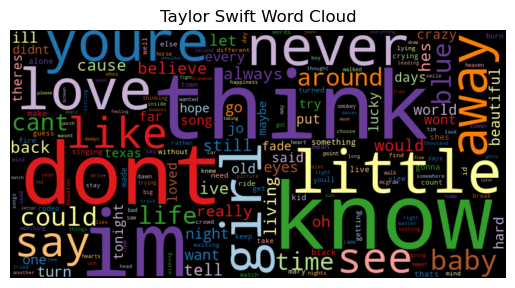

In [26]:
wordcloud(taylorswift_word_freq, "Taylor Swift Word Cloud")

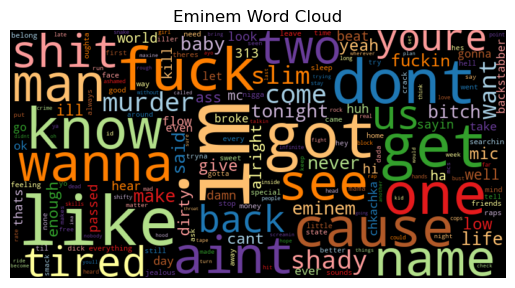

In [27]:
wordcloud(eminem_word_freq, "Eminem Word Cloud")

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: Taylor Swift's word cloud is more gentle and personal, as her songs are more about herself and her past experiences. Whereas, Eminem's word cloud is more vulgar and has no filter, as rap songs are mostyl just a fast-paced rhyme that has words only based on their rhythem and not based on making sense out of the whole verse. 

I like the visuals of Word Cloud, as they can help paint a better picture to show most commonly used elements in general word-scraping through reviews and web-contents.